# Section 1: Data Preparation

## Sec 1.1: Load data, split dataset, adjust variable names

In [5]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("XYZloan_default_selected_vars.csv")

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.40, random_state=42)

In [11]:
var = pd.DataFrame(train.dtypes)
var.head(5)

,0
Unnamed: 0.1,int64
Unnamed: 0,int64
id,int64
loan_default,int64
AP001,int64


In [12]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head(5)

,index,0
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [13]:
var.columns = ['varname','dtype'] 
var.head(5)

,varname,dtype
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [14]:
var['source'] = var['varname'].str[:2]
var.head(5)

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [15]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

## Sec 1.2: Remove bad feature

In [16]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [17]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

# Section 2: Prepare H20 Python Module for modeling

In [18]:
#pip install h2o

In [19]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 day 2 hours 40 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,"14 days, 7 hours and 38 minutes"
H2O_cluster_name:,H2O_from_python_ruxizhou_2mnm05
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.662 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [22]:
#from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
target='loan_default'

# Section 3: Modeling

## Sec 3.1: Random Forest

### What's Random Forest?
Random Forest is an ensemble learning method which builds multiple decision trees and combines their predictions, it can be applied in regression or classification tasks. When building decision tree, we randomly select datapoints to build different models from the dataset. The random forest method builds many decision trees and then takes the average for the outcomes of all the decision trees.

### Why Random Forest?
1. In anomaly detection, ensemble approach helps improve the model's robustness and generalization.
2. Random Forest handles imbalanced datasets well because, during the training of each tree, it randomly selects a subset of samples with replacement (bootstrapping). This allows the model to expose each tree to different variations of the dataset, including a diverse set of normal instances.
3. Also, the bagging process ensures that each tree in the forest sees a slightly different perspective of the dataset, making the model less sensitive to the majority class. 
4. Moreover, While training each tree, there is a set of samples that would not be included in the bootstrap sample. These out-of-bag samples can be used for validation.


### Sec 3.1.1: Random Forest with a small sample dataset

In [85]:
#try with a small sample dataset first
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [86]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [87]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         108003                 6            11           7.66          19            25            22.45

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14767353573534184
RMSE: 0.38428314526575563
MAE: 0.2957980576763411
RMSLE: 0.2694211114439255
Mean Residual Deviance: 0.14767353573534184

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.1477604099297664
RMSE: 0.3843961627406892
MAE: 0.29597600286172465
RMSLE: 0.26950533579774466
Mean Residual Deviance: 0.1477604099297664

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.295862  0.0105649   0.289865      0.288422      0.298811      0.300648      0.292843      0.314834      0.285189      0.299015      0.280622      0.30837
mean_residual_deviance  0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
mse                     0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
r2                      0.028792  0.0137831   0.00862054    0.0396453     0.0410812     0.0347524     0.0503409     0.0253746     0.0139032     0.0120922     0.0286377     0.0334718
residual_deviance       0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
rmse                    0.383921  0.0152529   0.375468      0.376155      0.389945      0.39179       0.382246      0.409737      0.36397       0.386362      0.362004      0.401536
rmsle                   0.269315  0.00791244  0.265959      0.264117      0.271659      0.273025      0.267234      0.283091      0.260066      0.272064      0.257598      0.278338

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-11-22 21:29:39  28.130 sec  0.0                nan                  nan                  nan
     2023-11-22 21:29:39  28.139 sec  1.0                0.3920307054589556   0.296256731487853    0.1536880740226464
     2023-11-22 21:29:39  28.146 sec  2.0                0.3942032053571326   0.29700516758134304  0.15539616711383766
     2023-11-22 21:29:39  28.152 sec  3.0                0.3904279147638411   0.2939797914789087   0.15243395662684114
     2023-11-22 21:29:39  28.159 sec  4.0                0.3901756870847142   0.2949471374634921   0.1522370667920288
     2023-11-22 21:29:39  28.166 sec  5.0                0.39045233521620937  0.29677616864784884  0.15245302607579111
     2023-11-22 21:29:39  28.174 sec  6.0                0.38983582738116856  0.2966234733230358   0.15197197230996023
     2023-11-22 21:29:39  28.181 sec  7.0                0.38914318695596034  0.2966341661783077   0.1514324199542415
     2023-11-22 21:29:39  28.188 sec  8.0                0.3882353582921885   0.295444631963733    0.150726693428264
     2023-11-22 21:29:39  28

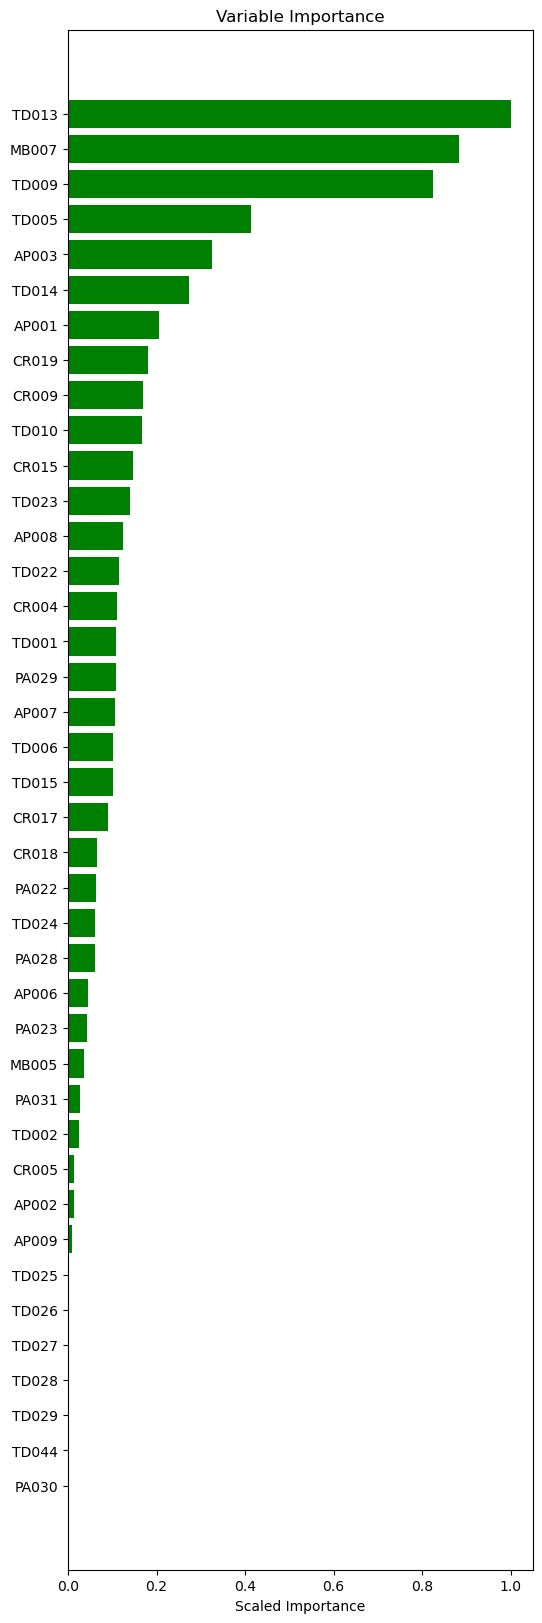

In [88]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(rf_v1)

In [89]:
predictions = rf_v1.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,loan_default,predict
0,0,0.274792
1,0,0.155529
2,0,0.120041
3,0,0.230445
4,0,0.120385


In [90]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(rf_v1)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,100,220,320,100,220,0.17,0.08,60.0,1.67,9.0,31.25
1,320,91,229,640,191,449,0.32,0.17,120.0,1.59,15.0,29.84
2,320,78,242,960,269,691,0.45,0.27,180.0,1.49,18.0,28.02
3,320,59,261,1280,328,952,0.55,0.37,240.0,1.37,18.0,25.62
4,320,63,257,1600,391,1209,0.65,0.46,300.0,1.30,19.0,24.44
5,320,54,266,1920,445,1475,0.74,0.57,360.0,1.24,17.0,23.18
6,320,40,280,2240,485,1755,0.81,0.68,420.0,1.15,13.0,21.65
7,320,56,264,2560,541,2019,0.90,0.78,480.0,1.13,12.0,21.13
8,320,34,286,2880,575,2305,0.96,0.89,540.0,1.06,7.0,19.97


In [91]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



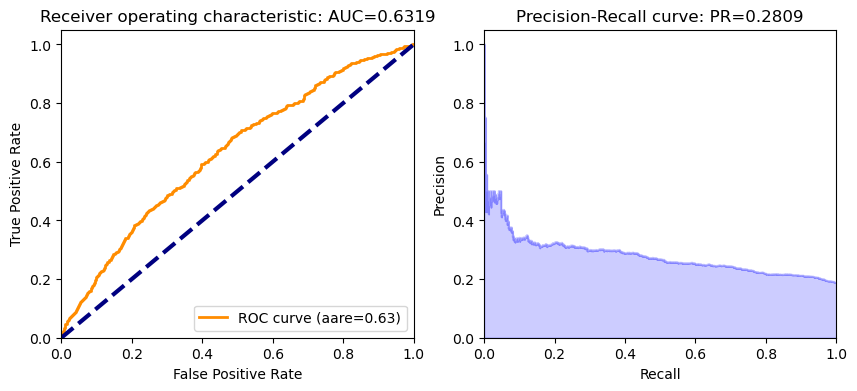

In [92]:
ROC_AUC(rf_v1,test_hex,'loan_default')

### Sec 3.1.2: Random Forest with whole dataset

#### Model 2

In [93]:
rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 200,
        nfolds=10,
        max_depth = 50,
        min_rows=20,
        seed=1234)
rf_v2.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    200                200                         298974                 12           20           14.17         91            117           108.495

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14818886706028367
RMSE: 0.3849530712441241
MAE: 0.29370942921535775
RMSLE: 0.2701975880210641
Mean Residual Deviance: 0.14818886706028367

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14836238584442468
RMSE: 0.38517838184979264
MAE: 0.2941534683957453
RMSLE: 0.27040995113818367
Mean Residual Deviance: 0.14836238584442468

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.294009   0.0105954   0.287265      0.28714       0.298259      0.298513      0.289507      0.313148      0.282233      0.297535      0.2802        0.306295
mean_residual_deviance  0.148182   0.0115082   0.14034       0.142644      0.154794      0.1543        0.145969      0.167612      0.132646      0.150416      0.132683      0.160415
mse                     0.148182   0.0115082   0.14034       0.142644      0.154794      0.1543        0.145969      0.167612      0.132646      0.150416      0.132683      0.160415
r2                      0.0248718  0.0138566   0.0130901     0.0318303     0.0238197     0.0297141     0.0512689     0.0269555     0.0126239     0.00454558    0.0165076     0.0383623
residual_deviance       0.148182   0.0115082   0.14034       0.142644      0.154794      0.1543        0.145969      0.167612      0.132646      0.150416      0.132683      0.160415
rmse                    0.384683   0.0149377   0.37462       0.377682      0.393439      0.392811      0.382059      0.409404      0.364206      0.387835      0.364257      0.400519
rmsle                   0.270196   0.00776484  0.265503      0.265509      0.274684      0.274173      0.267271      0.283388      0.260258      0.273443      0.25972       0.278008

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-11-22 21:30:18  32.106 sec  0.0                nan                  nan                  nan
     2023-11-22 21:30:18  32.120 sec  1.0                0.40989992238122097  0.29165427551728773  0.168017946368131
     2023-11-22 21:30:18  32.134 sec  2.0                0.40982439774853896  0.2933625175170108   0.16795603698995265
     2023-11-22 21:30:18  32.144 sec  3.0                0.406584056636543    0.29307501682083503  0.16531059511102764
     2023-11-22 21:30:18  32.159 sec  4.0                0.40447981439646874  0.29320188959845084  0.16360392025420178
     2023-11-22 21:30:18  32.175 sec  5.0                0.402110101823629    0.29340276166115603  0.16169253398860928
     2023-11-22 21:30:18  32.189 sec  6.0                0.40210224637877556  0.29480656605389194  0.16168621654285753
     2023-11-22 21:30:18  32.204 sec  7.0                0.40076283600441215  0.2951807919268171   0.16061085072229936
     2023-11-22 21:30:18  32.217 sec  8.0                0.3984085870165476   0.29378817474691243  0.15872940220852194
     2023-1

In [94]:
createGains(rf_v2)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,102,218,320,102,218,0.17,0.08,60.0,1.70,9.0,31.87
1,320,88,232,640,190,450,0.32,0.17,120.0,1.58,15.0,29.69
2,320,75,245,960,265,695,0.44,0.27,180.0,1.47,17.0,27.60
3,320,78,242,1280,343,937,0.57,0.36,240.0,1.43,21.0,26.80
4,320,54,266,1600,397,1203,0.66,0.46,300.0,1.32,20.0,24.81
5,320,44,276,1920,441,1479,0.74,0.57,360.0,1.23,17.0,22.97
6,320,53,267,2240,494,1746,0.82,0.67,420.0,1.18,15.0,22.05
7,320,45,275,2560,539,2021,0.90,0.78,480.0,1.12,12.0,21.05
8,320,37,283,2880,576,2304,0.96,0.89,540.0,1.07,7.0,20.00


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



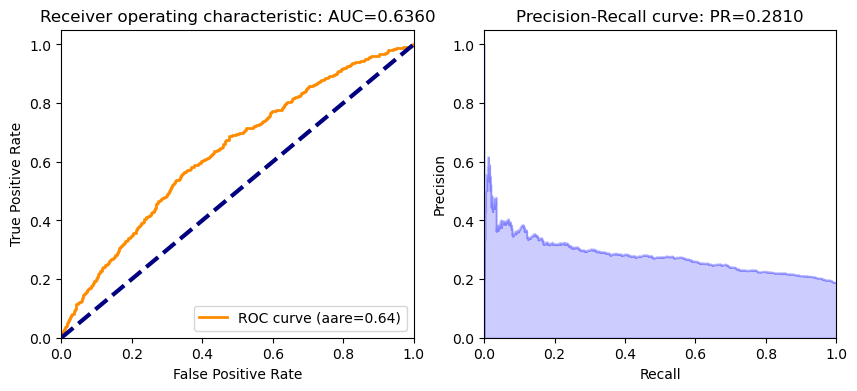

In [95]:
ROC_AUC(rf_v2,test_hex,'loan_default')

#### Model 3

In [99]:
rf_v3 = H2ORandomForestEstimator(
        model_id = 'rf_v3',
        ntrees = 100,
        nfolds=10,
        max_depth = 50,
        min_rows=20,
        balance_classes = True,
        seed=1234)
rf_v3.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         149858                 12           20           14.22         91            117           108.84

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.1485680787539809
RMSE: 0.38544529930196436
MAE: 0.29358650746762843
RMSLE: 0.2706094643802402
Mean Residual Deviance: 0.1485680787539809

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14851042949573715
RMSE: 0.3853705093747278
MAE: 0.29417448666211965
RMSLE: 0.2705553882401871
Mean Residual Deviance: 0.14851042949573715

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.294038   0.0105565   0.286751      0.287082      0.298281      0.299144      0.28991       0.312511      0.281996      0.297253      0.280622      0.306836
mean_residual_deviance  0.148331   0.0114271   0.139768      0.142828      0.154951      0.154902      0.146531      0.167338      0.132748      0.149888      0.133534      0.160817
mse                     0.148331   0.0114271   0.139768      0.142828      0.154951      0.154902      0.146531      0.167338      0.132748      0.149888      0.133534      0.160817
r2                      0.0238675  0.0125136   0.017113      0.0305809     0.0228313     0.0259298     0.0476158     0.0285444     0.0118642     0.00803939    0.0102018     0.0359541
residual_deviance       0.148331   0.0114271   0.139768      0.142828      0.154951      0.154902      0.146531      0.167338      0.132748      0.149888      0.133534      0.160817
rmse                    0.38488    0.0148233   0.373856      0.377926      0.393638      0.393576      0.382794      0.40907       0.364346      0.387153      0.365423      0.40102
rmsle                   0.270347   0.00765585  0.264923      0.265651      0.274792      0.274886      0.267875      0.283037      0.260301      0.273         0.260582      0.278422

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-11-22 21:32:56  14.606 sec  0.0                nan                  nan                  nan
     2023-11-22 21:32:56  14.627 sec  1.0                0.40989992238122097  0.29165427551728773  0.168017946368131
     2023-11-22 21:32:56  14.642 sec  2.0                0.40982439774853896  0.2933625175170108   0.16795603698995265
     2023-11-22 21:32:56  14.653 sec  3.0                0.406584056636543    0.29307501682083503  0.16531059511102764
     2023-11-22 21:32:56  14.666 sec  4.0                0.40447981439646874  0.29320188959845084  0.16360392025420178
     2023-11-22 21:32:56  14.688 sec  5.0                0.402110101823629    0.29340276166115603  0.16169253398860928
     2023-11-22 21:32:56  14.704 sec  6.0                0.40210224637877556  0.29480656605389194  0.16168621654285753
     2023-11-22 21:32:56  14.720 sec  7.0                0.40076283600441215  0.2951807919268171   0.16061085072229936
     2023-11-22 21:32:56  14.735 sec  8.0                0.3984085870165476   0.29378817474691243  0.15872940220852194
     2023-11-22

In [100]:
createGains(rf_v3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,102,218,320,102,218,0.17,0.08,60.0,1.70,9.0,31.87
1,320,85,235,640,187,453,0.31,0.17,120.0,1.56,14.0,29.22
2,320,79,241,960,266,694,0.44,0.27,180.0,1.48,17.0,27.71
3,320,72,248,1280,338,942,0.56,0.36,240.0,1.41,20.0,26.41
4,320,62,258,1600,400,1200,0.67,0.46,300.0,1.33,21.0,25.00
5,320,42,278,1920,442,1478,0.74,0.57,360.0,1.23,17.0,23.02
6,320,48,272,2240,490,1750,0.82,0.67,420.0,1.17,15.0,21.88
7,320,49,271,2560,539,2021,0.90,0.78,480.0,1.12,12.0,21.05
8,320,38,282,2880,577,2303,0.96,0.89,540.0,1.07,7.0,20.03


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



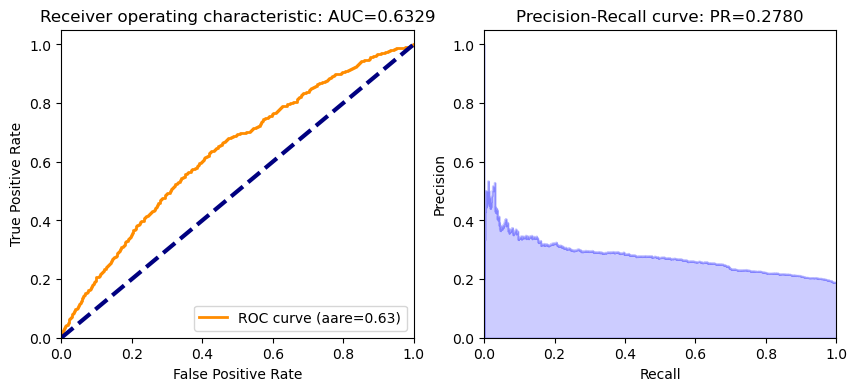

In [101]:
ROC_AUC(rf_v3,test_hex,'loan_default')

### Random Forest Analysis:

1. Modeling with small group of data allows us for quick iterative feedback, if there are improvements or debug needed, we can make changes more rapidly. Also, since training a model on a small dataset is computationally faster, if there is debug needed, we can modify them with less time;
2. K-Fold cross validation: In K-Fold CV, we further split our training set into K number of subsets, We then iteratively fit the model K times, each time training the data on K-1 of the folds and evaluating on the Kth fold. This approach can help us avoid overfitting because it train and test data in each folds, thus avoiding model learn too well in train dataset and gives accurate predictions for training data but not for new data(test).

* Hypertuning process in 3 models: 
1. In model 1, we set the ntrees=300, nfolds=10, min_rows=100, achieved AUC=0.6319; then I tried ntrees=200, nfolds=10, max_depth=50,min_rows=20, achieved AUC=0.6360; in model 3, ntrees = 100, nfolds=10,max_depth = 50, min_rows=20,balance_classes = True; achieved AUC 0.6329
2. The outcome of 3 models in their test dataset is quite similar, the hypertuning parameter process didn't get significant progress, and the best model among 3 RF models is model2

# Section 4: Dealing with imbalanced dataset

In [102]:
y = data[target]
X = data.drop(target,axis=1)
y.dtypes

dtype('int64')

In [103]:
y1_cnt = data[target].sum()
y1_cnt

15488

In [104]:
N = 2
y0_cnt = y1_cnt * N
y0_cnt

30976

## Sec 4.1: Undersampling

### What's Undersampling?
Undersampling is a technique to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class. It is a technique that can use to extract more accurate information from originally imbalanced datasets.

### Why undersampling?
Training a machine learning model on imbalanced data can lead to models that perform poorly on the minority class (anomalies). By undersampling the majority class, the model can be trained more efficiently, as it focuses on a more balanced dataset.

In [105]:
#pip install imblearn

In [106]:
from imblearn.datasets import make_imbalance
X_rs, y_rs = make_imbalance(X, y, 
                            sampling_strategy={1:y1_cnt , 0:  y0_cnt},
                            random_state=0)
X_rs = pd.DataFrame(X_rs)
y_rs = pd.DataFrame(y_rs) 

In [107]:
y_rs = data[data[target]==1]
X_rs = data[data[target]==0].sample(n=y0_cnt)
smpl = pd.concat([X_rs,y_rs])
smpl_hex = h2o.H2OFrame(smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [108]:
rf_v4 = H2ORandomForestEstimator(
        model_id = 'rf_v4',
        ntrees = 200,
        nfolds=10,
        max_depth = 50,
        min_rows=20,
        seed=1234)
rf_v4.train(predictors,target,training_frame=smpl_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v4


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    200                200                         3.02036e+06            18           27           21.865        1055          1123          1100.02

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.20658424281676002
RMSE: 0.45451539337712205
MAE: 0.41283348179340185
RMSLE: 0.3193974258502353
Mean Residual Deviance: 0.20658424281676002

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.20631862950170962
RMSE: 0.4542231054247567
MAE: 0.4129036716010217
RMSLE: 0.31917902495478667
Mean Residual Deviance: 0.20631862950170962

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.412903   0.00225019  0.413594      0.414904      0.409611      0.409828      0.411808      0.412914      0.413823      0.416108      0.415255      0.411186
mean_residual_deviance  0.20632    0.00227812  0.207419      0.208654      0.203291      0.203436      0.205224      0.205763      0.207273      0.209081      0.209024      0.204039
mse                     0.20632    0.00227812  0.207419      0.208654      0.203291      0.203436      0.205224      0.205763      0.207273      0.209081      0.209024      0.204039
r2                      0.0714385  0.00489116  0.0730676     0.0747427     0.0760904     0.0704746     0.0736759     0.0762993     0.0652632     0.0615067     0.0690163     0.0742484
residual_deviance       0.20632    0.00227812  0.207419      0.208654      0.203291      0.203436      0.205224      0.205763      0.207273      0.209081      0.209024      0.204039
rmse                    0.454219   0.00250837  0.455433      0.456787      0.450878      0.451039      0.453017      0.453611      0.455273      0.457254      0.457192      0.451707
rmsle                   0.319175   0.00122044  0.319082      0.319624      0.317361      0.318022      0.31884       0.318691      0.320089      0.321341      0.320501      0.318204

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-11-22 21:42:36  7 min 23.571 sec  0.0                nan                  nan                  nan
     2023-11-22 21:42:36  7 min 23.757 sec  1.0                0.49059106579027295  0.41001738903663026  0.24067959383323595
     2023-11-22 21:42:36  7 min 23.944 sec  2.0                0.48623510503773276  0.41170323327556724  0.23642457737105502
     2023-11-22 21:42:36  7 min 24.161 sec  3.0                0.4840494908035788   0.4129632455776148   0.2343039095472039
     2023-11-22 21:42:37  7 min 24.344 sec  4.0                0.481233239956969    0.4138540739475211   0.23158543123948166
     2023-11-22 21:42:37  7 min 24.551 sec  5.0                0.47791829621890924  0.4135694459902484   0.22840589786078508
     2023-11-22 21:42:37  7 min 24.741 sec  6.0                0.4750838244839248   0.41356857858988316  0.22570464028627263
     2023-11-22 21:42:37  7 min 24.942 sec  7.0                0.4724039186335603   0.4134873857562634   0.22316546234034343
     2023-11-22 21:42:37  7 min 25.121 sec  8.0                0.4701

In [111]:
createGains(rf_v4)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,189,131,320,189,131,0.32,0.05,60.0,3.15,27.0,59.06
1,320,131,189,640,320,320,0.53,0.12,120.0,2.67,41.0,50.00
2,320,98,222,960,418,542,0.70,0.21,180.0,2.32,49.0,43.54
3,320,70,250,1280,488,792,0.81,0.30,240.0,2.03,51.0,38.12
4,320,43,277,1600,531,1069,0.88,0.41,300.0,1.77,47.0,33.19
5,320,33,287,1920,564,1356,0.94,0.52,360.0,1.57,42.0,29.38
6,320,21,299,2240,585,1655,0.98,0.64,420.0,1.39,34.0,26.12
7,320,10,310,2560,595,1965,0.99,0.76,480.0,1.24,23.0,23.24
8,320,4,316,2880,599,2281,1.00,0.88,540.0,1.11,12.0,20.80


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



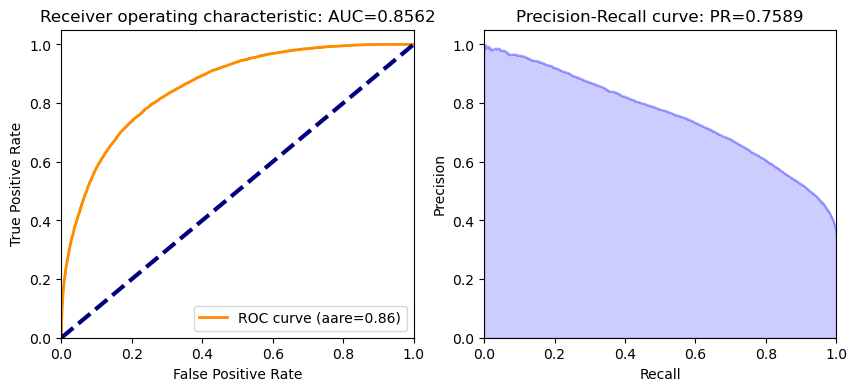

In [109]:
ROC_AUC(rf_v4,smpl_hex,'loan_default')

### Undersampling Analysis:

1. After undersampling dataset, we continue to use the parameters that has best performance(model 2)
2. The RF model performs better after undersampling, achieve AUC=0.86 in train dataset, and AUC=0.83 in test dataset.

## Sec 4.2: Oversampling

### What's Undersampling?
Oversampling is a ML technique used to address class imbalance in a dataset. In oversampling, the idea is to increase the number of instances in the minority class to balance the class distribution. 

### Why undersampling?
The goal is to create a more balanced dataset, allowing ML models to better learn patterns associated with the minority class and make more accurate predictions.

In [114]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [115]:
y_resampled = data[data[target]==1]
X_resampled = data[data[target]==0].sample(n=y0_cnt)
smpl = pd.concat([X_resampled,y_resampled])
smpl_hex = h2o.H2OFrame(smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [116]:
rf_v5 = H2ORandomForestEstimator(
        model_id = 'rf_v5',
        ntrees = 200,
        nfolds=10,
        max_depth = 50,
        min_rows=20,
        seed=1234)
rf_v5.train(predictors,target,training_frame=smpl_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v5


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    200                200                         3.02224e+06            19           27           21.795        1060          1124          1099.58

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.20657097019127554
RMSE: 0.4545007922889415
MAE: 0.4128126899425907
RMSLE: 0.3194021632404344
Mean Residual Deviance: 0.20657097019127554

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.20631385601627547
RMSE: 0.4542178508340194
MAE: 0.41289548507347257
RMSLE: 0.31919078191302996
Mean Residual Deviance: 0.20631385601627547

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.4129     0.00292139  0.413142      0.417954      0.411586      0.408961      0.413865      0.412356      0.412486      0.4147        0.415693      0.40826
mean_residual_deviance  0.20632    0.0028672   0.207083      0.210729      0.204777      0.20232       0.207171      0.205274      0.206204      0.208077      0.209662      0.201905
mse                     0.20632    0.0028672   0.207083      0.210729      0.204777      0.20232       0.207171      0.205274      0.206204      0.208077      0.209662      0.201905
r2                      0.0714606  0.00644481  0.0745689     0.0655405     0.0693369     0.0755762     0.0648865     0.0784912     0.0700857     0.0660137     0.0661752     0.0839314
residual_deviance       0.20632    0.0028672   0.207083      0.210729      0.204777      0.20232       0.207171      0.205274      0.206204      0.208077      0.209662      0.201905
rmse                    0.454215   0.00315762  0.455064      0.459053      0.452522      0.4498        0.455161      0.453072      0.454097      0.456155      0.457889      0.449339
rmsle                   0.319189   0.00173971  0.318877      0.321696      0.318907      0.317089      0.320555      0.318197      0.319054      0.320354      0.320971      0.316194

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-11-22 22:30:27  7 min 59.874 sec  0.0                nan                  nan                  nan
     2023-11-22 22:30:27  8 min  0.112 sec  1.0                0.49240189706380255  0.41330605245379354  0.24245962823203163
     2023-11-22 22:30:27  8 min  0.318 sec  2.0                0.48831802907624405  0.4141679560457583   0.23845449752090755
     2023-11-22 22:30:27  8 min  0.518 sec  3.0                0.48432842811456356  0.41462686185850495  0.23457402627992396
     2023-11-22 22:30:27  8 min  0.715 sec  4.0                0.4809309666796424   0.41454671685488087  0.2312945947114153
     2023-11-22 22:30:28  8 min  0.911 sec  5.0                0.47758436703048607  0.41403767614523546  0.22808682763191002
     2023-11-22 22:30:28  8 min  1.104 sec  6.0                0.4747637933107081   0.4137399078674941   0.2254006594387728
     2023-11-22 22:30:28  8 min  1.296 sec  7.0                0.47200577718542164  0.41327905373642704  0.2227894536964139
     2023-11-22 22:30:28  8 min  1.545 sec  8.0                0.46977505

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



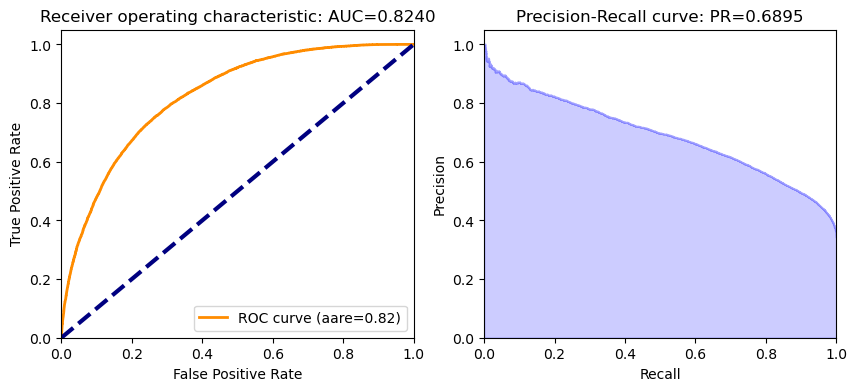

In [117]:
ROC_AUC(rf_v4,smpl_hex,'loan_default')

### Oversampling Analysis:

1. After oversampling dataset, we continue to use the parameters that has best performance(model 2)
2. The RF model performs better after oversampling, achieve AUC=0.86 in train dataset.

# Summary

1. Using oversampling/undersampling can greatly help us to deal with imbalanced data, we achieved approximately 20% accuracy improvement in overall predicting;
2. The Precision is directly influenced by class imbalance so the Precision-recall curves are better to highlight differences between models for highly imbalanced data sets, after sampling technique, the PR curve had great improvement;
3. Model 4 has the best performance among all 5 models, with the highest AUC in train dataset achieved 0.86, the undersampling technique with RF model in this case is slightly better than oversampling with RF model.